In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import pickle
import re
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from scipy.stats import shapiro 
from scipy.stats import kstest
import EntropyHub as EH
from scipy import interpolate
import math

In [2]:
D1_data=pd.read_pickle('../data/dataset/D1_puregooddata_split_31032023.pkl')

In [3]:
class pain_monitering_D1:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D1_time=[]
        self.D1_prediction=-1
        self.D1_confidence=-1
    def __str__(self):
        print("participant: "+self.PID)
        print("Day 1 rating: "+str(len(self.D1_rating))+" sessions")
        print("Day 1 timing: "+str(len(self.D1_time))+" sessions")
        print("Day 1 prediction: "+ str(self.D1_prediction))
        print("Day 1 confidence: "+ str(self.D1_confidence))
        return ""
    def update_rating_time(self,rating,time):
        self.D1_rating=rating
        self.D1_time=time
    def update_prediction_confidence(self,pred,conf):
        self.D1_prediction=pred
        self.D1_confidence=conf

In [4]:
Day1_participant_list=[]
for i,pid in enumerate(D1_data['PID']):
    partcipant=pain_monitering_D1(pid)
    partcipant.update_rating_time(D1_data['rating'][i],D1_data['time'][i])
    partcipant.update_prediction_confidence(D1_data['prediction'][i],D1_data['confidence'][i])
    Day1_participant_list.append(partcipant)
print(str(len(Day1_participant_list))+" participants")

79 participants


In [5]:
def downsample(rating, time,samplingrate):
    rating_downsample_list = []
    time_downsample_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            original_timing = time[i]
            original_rating = rating[i]
            flinear = interpolate.interp1d(original_timing, original_rating)
            new_timing = np.arange(round_up(original_timing[0],1),round_down(original_timing[-1],1),1/samplingrate)
            ylinear = flinear(new_timing)
            rating_downsample_list.append(ylinear)
            time_downsample_list.append(new_timing)
        else:
            rating_downsample_list.append([np.nan])
            time_downsample_list.append([np.nan])
    return rating_downsample_list, time_downsample_list
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

### downsample to 40Hz (0.025 s)
+ original sampling rate is nearly 55 Hz

In [6]:
downsample_rate=40

In [7]:
Day1_part_downsample_list=[]
for part in Day1_participant_list:
    partcipant=pain_monitering_D1(part.PID)
    partcipant.update_prediction_confidence(part.D1_prediction,part.D1_confidence)
    rating,time=downsample(part.D1_rating,part.D1_time,downsample_rate)
    partcipant.update_rating_time(rating,time)
    Day1_part_downsample_list.append(partcipant)

In [ ]:
D1_data["Day1_part_downsample_list"]=Day1_part_downsample_list
D1_data.to_pickle("../data/dataset/D1_data_downsample.pkl")

### distribution of the number of time points

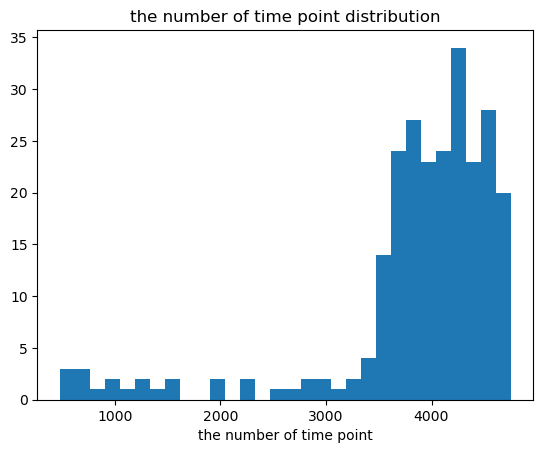

min: 480
max: 4752


In [8]:
count_list=[]
for part in Day1_part_downsample_list:
    for rating in part.D1_rating:
        count_list.append(len(rating))
# plt.xlim(0,np.log(12))
plt.xlabel("the number of time point")
plt.title("the number of time point distribution")
plt.hist(count_list, bins=30)
plt.show()
print("min: "+str(min(count_list)))
print("max: "+str(max(count_list)))

### the length of sliding window
+ the SampEn is significantly independent of the
time series length when the number of data points is larger than 750
+ temporary length: 470

In [9]:
def create_sliding_window(rating_list,time_list,window_length):
    rating_window_list=[]
    time_window_list=[]
    for j,rating in enumerate(rating_list):
        rating_window=[]
        time_window=[]
        for i in range(len(rating)-window_length+1):
            rating_window.append(rating[i:i+window_length])
            time_window.append(time_list[j][i:i+window_length])
        rating_window_list.append(rating_window)
        time_window_list.append(time_window)
    return rating_window_list,time_window_list

In [10]:
window_length=470

In [11]:
Day1_part_window_list=[]
for part in Day1_part_downsample_list:
    partcipant=pain_monitering_D1(part.PID)
    partcipant.update_prediction_confidence(part.D1_prediction,part.D1_confidence)
    rating,time=create_sliding_window(part.D1_rating,part.D1_time,window_length)
    partcipant.update_rating_time(rating,time)
    Day1_part_window_list.append(partcipant)

### calculate different type of entropy
+ approximate entropy
+ sample entropy
+ multiscale entropy
+ composite multiscale entropy

In [12]:
class partcipant_entropy:
    def __init__(self,PID,TYPE):
        self.PID=PID
        self.EnType=TYPE
        self.entropy_list=[]
        self.time_list=[]
        self.CI_list=[]
    def update_entropy(self,entropy,time):
        self.entropy_list.append(entropy)
        self.time_list.append(time)
    def update_complexity(self,CI):
        self.CI_list.append(CI)

In [42]:
part_ApEn_list=[]
part_SEn_list=[]
part_MSEn_list=[]
# part_CMSEn_list=[]
Mobj = EH.MSobject('SampEn')
for p_count,part in enumerate(Day1_part_window_list):
    part_ApEn=partcipant_entropy(part.PID,'approximate entropy')
    part_SEn=partcipant_entropy(part.PID,'sample entropy')
    part_MSEn=partcipant_entropy(part.PID,'multiscale entropy')
    # part_CMSEn=partcipant_entropy(part.PID,'composite multiscale entropy')
    for i,trial in enumerate(part.D1_rating):
        timepoint_list=[]
        Ap_list=[]
        Samp_list=[]
        MSE_list=[]
        CI_MS_list=[]
        # CMSE_list=[]
        # CI_CMS_list=[]
        for j,Segm in enumerate(trial):
            timepoint=part.D1_time[i][j][window_length//2]
            Ap, Phi = EH.ApEn(Segm,m=3)
            Samp,A,B=EH.SampEn(Segm,m=3)
            MSE,CI_MS = EH.MSEn(Segm,Mobj)
            # CMSE, CI_CMS = EH.cMSEn(Segm,Mobj)
            timepoint_list.append(timepoint)
            Ap_list.append(Ap)
            Samp_list.append(Samp)
            MSE_list.append(MSE)
            CI_MS_list.append(CI_MS)
            # CMSE_list.append(CMSE[-1])
            # CI_CMS_list.append(CI_CMS)
        part_ApEn.update_entropy(Ap_list,timepoint_list)
        part_SEn.update_entropy(Samp_list,timepoint_list)
        part_MSEn.update_entropy(MSE_list,timepoint_list)
        # part_CMSEn.update_entropy(CMSE_list,timepoint_list)
        part_MSEn.update_complexity(CI_MS_list)
        # part_CMSEn.update_complexity(CI_CMS_list)
    part_ApEn_list.append(part_ApEn)
    part_SEn_list.append(part_SEn)
    part_MSEn_list.append(part_MSEn)
    # part_CMSEn_list.append(part_CMSEn)
    if p_count>2:
        break
            


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [43]:
ApEn_m_1_p0=[]
ApEn_m_2_p0=[]
ApEn_m_3_p0=[]
SampEn_m_1_p0=[]
SampEn_m_2_p0=[]
SampEn_m_3_p0=[]
MSEn_m_1_p0=[]
MSEn_m_2_p0=[]
MSEn_m_3_p0=[]
timelist=[]
for i,session in enumerate(part_ApEn_list[0].entropy_list):
    en_session_0=[]
    en_session_1=[]
    en_session_2=[]
    for j,en_diffm in enumerate(session):
        for t,en in enumerate(en_diffm):
            if t==1:
                en_session_0.append(en)
            elif t==2:
                en_session_1.append(en)
            elif t==3:
                en_session_2.append(en)
    ApEn_m_1_p0.append(en_session_0)
    ApEn_m_2_p0.append(en_session_1)
    ApEn_m_3_p0.append(en_session_2)
for i,session in enumerate(part_SEn_list[0].entropy_list):
    en_session_0=[]
    en_session_1=[]
    en_session_2=[]
    for j,en_diffm in enumerate(session):
        for t,en in enumerate(en_diffm):
            if t==1:
                en_session_0.append(en)
            elif t==2:
                en_session_1.append(en)
            elif t==3:
                en_session_2.append(en)
    SampEn_m_1_p0.append(en_session_0)
    SampEn_m_2_p0.append(en_session_1)
    SampEn_m_3_p0.append(en_session_2)
for i,session in enumerate(part_MSEn_list[0].entropy_list):
    en_session_0=[]
    en_session_1=[]
    en_session_2=[]
    for j,en_diffm in enumerate(session):
        for t,en in enumerate(en_diffm):
            if t==0:
                en_session_0.append(en)
            elif t==1:
                en_session_1.append(en)
            else:
                en_session_2.append(en)
    MSEn_m_1_p0.append(en_session_0)
    MSEn_m_2_p0.append(en_session_1)
    MSEn_m_3_p0.append(en_session_2)

### comparison among different entropy strategies
+ approximate entropy
+ sample entropy
+ multiscale entropy

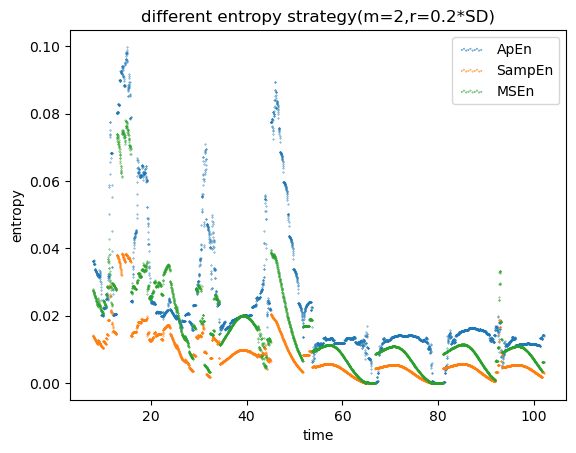

In [45]:
En_list_diff_method=[ApEn_m_2_p0[0],SampEn_m_2_p0[0],MSEn_m_2_p0[0]]
for i,session_1_diffm in enumerate(En_list_diff_method):
    plt.scatter(part_SEn_list[0].time_list[0], session_1_diffm, s=0.1)
plt.legend(labels=['ApEn','SampEn','MSEn'],loc='best',scatterpoints=10)
plt.title("different entropy strategy(m=2,r=0.2*SD)")
plt.xlabel("time")
plt.ylabel("entropy")
plt.show()

### entropy distribution of 

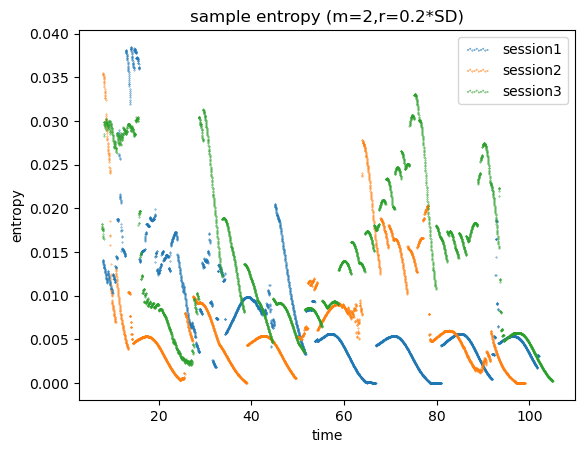

In [47]:
for i,session in enumerate(SampEn_m_2_p0):
    plt.scatter(part_SEn_list[0].time_list[i], session, s=0.1,label='session'+str(i+1))
plt.legend(scatterpoints=10)
plt.title("sample entropy (m=2,r=0.2*SD)")
plt.xlabel("time")
plt.ylabel("entropy")
plt.show()

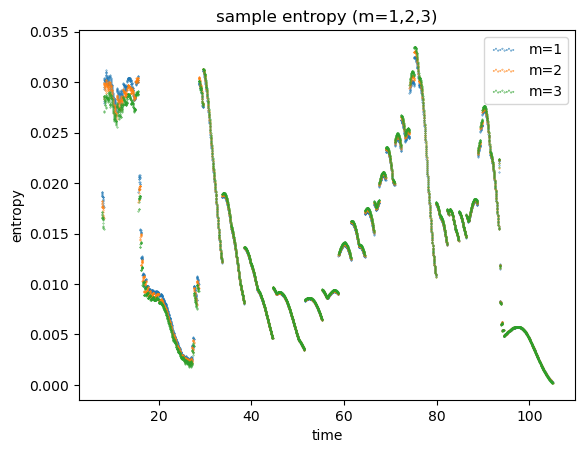

In [50]:
diffm_en_list=[SampEn_m_1_p0[2],SampEn_m_2_p0[2],SampEn_m_3_p0[2]]
for i,session_1_diffm in enumerate(diffm_en_list):
    plt.scatter(part_SEn_list[0].time_list[2], session_1_diffm, s=0.1,label='m='+str(i+1))
plt.legend(scatterpoints=10)
plt.title("sample entropy (m=1,2,3)")
plt.xlabel("time")
plt.ylabel("entropy")
plt.show()

In [51]:
ApEn_m_1_p1=[]
ApEn_m_2_p1=[]
ApEn_m_3_p1=[]
SampEn_m_1_p1=[]
SampEn_m_2_p1=[]
SampEn_m_3_p1=[]
MSEn_m_1_p1=[]
MSEn_m_2_p1=[]
MSEn_m_3_p1=[]
timelist=[]
for i,session in enumerate(part_ApEn_list[1].entropy_list):
    en_session_0=[]
    en_session_1=[]
    en_session_2=[]
    for j,en_diffm in enumerate(session):
        for t,en in enumerate(en_diffm):
            if t==1:
                en_session_0.append(en)
            elif t==2:
                en_session_1.append(en)
            elif t==3:
                en_session_2.append(en)
    ApEn_m_1_p1.append(en_session_0)
    ApEn_m_2_p1.append(en_session_1)
    ApEn_m_3_p1.append(en_session_2)
for i,session in enumerate(part_SEn_list[1].entropy_list):
    en_session_0=[]
    en_session_1=[]
    en_session_2=[]
    for j,en_diffm in enumerate(session):
        for t,en in enumerate(en_diffm):
            if t==1:
                en_session_0.append(en)
            elif t==2:
                en_session_1.append(en)
            elif t==3:
                en_session_2.append(en)
    SampEn_m_1_p1.append(en_session_0)
    SampEn_m_2_p1.append(en_session_1)
    SampEn_m_3_p1.append(en_session_2)
for i,session in enumerate(part_MSEn_list[1].entropy_list):
    en_session_0=[]
    en_session_1=[]
    en_session_2=[]
    for j,en_diffm in enumerate(session):
        for t,en in enumerate(en_diffm):
            if t==0:
                en_session_0.append(en)
            elif t==1:
                en_session_1.append(en)
            else:
                en_session_2.append(en)
    MSEn_m_1_p1.append(en_session_0)
    MSEn_m_2_p1.append(en_session_1)
    MSEn_m_3_p1.append(en_session_2)

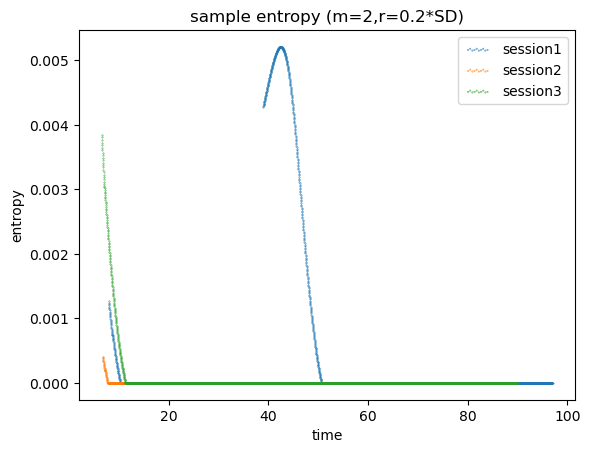

In [52]:
for i,session in enumerate(SampEn_m_2_p1):
    plt.scatter(part_SEn_list[1].time_list[i], session, s=0.1,label='session'+str(i+1))
plt.legend(scatterpoints=10)
plt.title("sample entropy (m=2,r=0.2*SD)")
plt.xlabel("time")
plt.ylabel("entropy")
plt.show()

In [54]:
PID_list=[]
ApEn_m_1=[]
ApEn_m_2=[]
ApEn_m_3=[]
SampEn_m_1=[]
SampEn_m_2=[]
SampEn_m_3=[]
MSEn_m_1=[]
MSEn_m_2=[]
MSEn_m_3=[]
timelist=[]
for part in part_ApEn_list:
    PID_list.append(part.PID)
    ApEn_m_1_part=[]
    ApEn_m_2_part=[]
    ApEn_m_3_part=[]
    for i,session in enumerate(part.entropy_list):
        en_session_0=[]
        en_session_1=[]
        en_session_2=[]
        for j,en_diffm in enumerate(session):
            for t,en in enumerate(en_diffm):
                if t==1:
                    en_session_0.append(en)
                elif t==2:
                    en_session_1.append(en)
                elif t==3:
                    en_session_2.append(en)
        ApEn_m_1_part.append(en_session_0)
        ApEn_m_2_part.append(en_session_1)
        ApEn_m_3_part.append(en_session_2)
    ApEn_m_1.append(ApEn_m_1_part)
    ApEn_m_2.append(ApEn_m_2_part)
    ApEn_m_3.append(ApEn_m_3_part)
for part in part_SEn_list:
    SampEn_m_1_part=[]
    SampEn_m_2_part=[]
    SampEn_m_3_part=[]
    for i,session in enumerate(part.entropy_list):
        en_session_0=[]
        en_session_1=[]
        en_session_2=[]
        for j,en_diffm in enumerate(session):
            for t,en in enumerate(en_diffm):
                if t==1:
                    en_session_0.append(en)
                elif t==2:
                    en_session_1.append(en)
                elif t==3:
                    en_session_2.append(en)
        SampEn_m_1_part.append(en_session_0)
        SampEn_m_2_part.append(en_session_1)
        SampEn_m_3_part.append(en_session_2)
    SampEn_m_1.append(SampEn_m_1_part)
    SampEn_m_2.append(SampEn_m_2_part)
    SampEn_m_3.append(SampEn_m_3_part)
for part in part_MSEn_list:
    MSEn_m_1_part=[]
    MSEn_m_2_part=[]
    MSEn_m_3_part=[]
    for i,session in enumerate(part.entropy_list):
        en_session_0=[]
        en_session_1=[]
        en_session_2=[]
        for j,en_diffm in enumerate(session):
            for t,en in enumerate(en_diffm):
                if t==0:
                    en_session_0.append(en)
                elif t==1:
                    en_session_1.append(en)
                else:
                    en_session_2.append(en)
        MSEn_m_1_part.append(en_session_0)
        MSEn_m_2_part.append(en_session_1)
        MSEn_m_3_part.append(en_session_2)
    MSEn_m_1.append(MSEn_m_1_part)
    MSEn_m_2.append(MSEn_m_1_part)
    MSEn_m_3.append(MSEn_m_1_part)

In [60]:
len(part_ApEn_list)

4

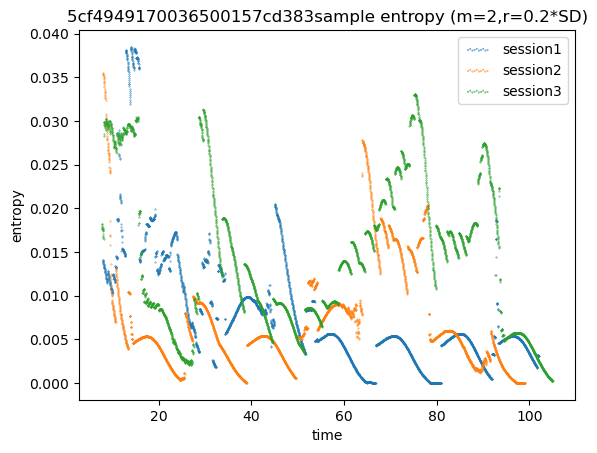

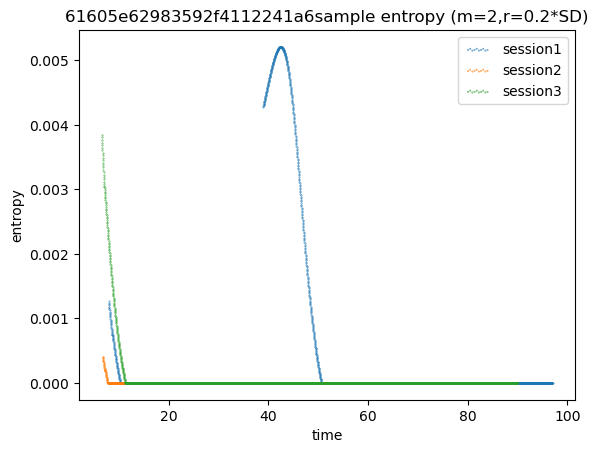

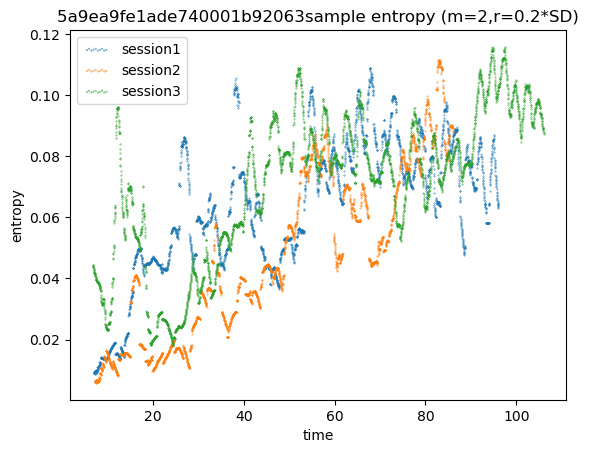

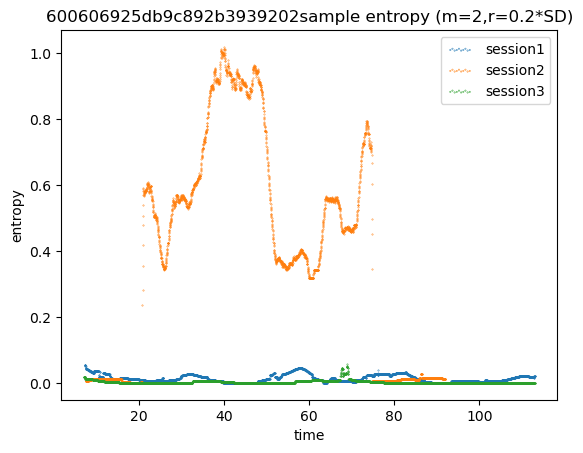

In [58]:
for j,part in enumerate(SampEn_m_2):
    for i,session in enumerate(part):
        plt.scatter(part_SEn_list[j].time_list[i], session, s=0.1,label='session'+str(i+1))
    plt.legend(scatterpoints=10)
    plt.title(PID_list[j]+"sample entropy (m=2,r=0.2*SD)")
    plt.xlabel("time")
    plt.ylabel("entropy")
    plt.savefig("../data/image/Day_1_SampEn2/"+PID_list[j]+"_SampEn2.jpg",bbox_inches='tight')
    plt.show()